In [1]:
import os
from PIL import Image
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras_tuner
from keras_tuner import RandomSearch

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import os

import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
num_skipped = 0
folders = ("data1/covid", "data1/normal")

for folder_name in folders:
    folder_path = folder_name
    for fname in os.listdir(folder_path):
        fpath = "./"+folder_path+"/"+fname
        try:
            fobj = Image.open(fpath)
            fobj.verify()
        except Exception:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        finally:
            fobj.close()


print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (256, 256) #image resize parameter
BATCH_SIZE = 32 #parameter for mini-batch learning
validation_split = 0.2 #0.1 for validation, 0.1 for test will be used
seed = 548 #seed for shuffling and other random operations
EPOCHS = 15 #max epochs to train
img_height, img_width = image_size[0], image_size[1]
#early stopping for training
es = EarlyStopping(monitor="val_loss",
                   min_delta=0,
                   verbose=1,
                   mode="min",
                   patience=5,
                   restore_best_weights=True)   

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255, #scaling the images
    validation_split=0.2 #validation/test split, 0.1 for validation
    #0.1 for test
    )

train_generator = train_datagen.flow_from_directory(
    "data1", #data directory
    target_size=image_size, #image size for resizing
    batch_size=99999, #since we are going to unpack the generator
    #we want a batch to include all data
    shuffle = True, #shuffle the data before using it
    seed = seed, #using a set seed for random operations for
    #reproducibility
    class_mode='binary', #setting for binary classification
    color_mode="grayscale", #turn images to grayscale
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    "data1", 
    target_size=image_size,
    batch_size=99999,
    shuffle = True,
    seed = seed,
    class_mode='binary',
    color_mode="grayscale",
    subset='validation')

Found 2440 images belonging to 2 classes.
Found 610 images belonging to 2 classes.


In [6]:
#unpack the dataset
train_img, train_labels = train_generator.next()
validation_img, validation_labels = validation_generator.next()


In [7]:
#split validation further into 0.1 test and 0.1 validation
split_labels = np.array_split(validation_labels, 2)
split_img = np.array_split(validation_img, 2)
test_labels = split_labels[0]
test_img = split_img[0]
validation_labels = split_labels[1]
validation_img = split_img[1]

In [8]:
#the model building function we use for tuning
def build_model(hp):
    inputs = keras.Input(shape=(img_height, img_width, 1)) #input layer
    x = inputs
    
    #layer number to be used for both convolution and deep layer
    layerNum = hp.Choice("cnn_layers", values = [1, 3])
    for i in range(layerNum):
        x = layers.Conv2D(
            hp.Choice(f'conv_filters{i}', values = [16, 32, 64]), #filter size hyperparameter
            kernel_size=hp.Choice(f'kernel_size{i}', values = [1, 3]), #kernel size hyperparameter
            activation="relu",
        )(x)
        x = layers.BatchNormalization()(x) #normalize the batch
        #It is of debate topic whether to use the batch normalization before or after the activation layer.
        #Some suggest that using it before helps, some suggest that it defeats the purpose of normalization
        #to use it before the activation layer. We used it after the activation layer.
        x = layers.MaxPooling2D()(x) #downsample the data
        
    x = layers.Flatten()(x) #flatten the output for dense layers

    #hyperparamter for whether to use a dropout layer.
    dropBool = hp.Boolean("dropout")
    for i in range(layerNum):
        layers.Dense(units=hp.Choice(f'dense_units{i}', values = [8, 64, 128]), #dense unit size parameter
                     activation="relu")(x)
        if dropBool:
            x = layers.Dropout(0.5)(x)

    #the last layer contains 1 unit,
    #since we will be doing binary classification.
    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    #compile the model.
    model.compile(
        loss="binary_crossentropy", metrics=["accuracy"], #binary cross entropy is used for the loss function
        optimizer=keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-1, 1e-3])), #learning rate hyperparameter
    )
    return model

In [9]:
tuner = keras_tuner.RandomSearch(
    build_model,
    max_trials=50, #maximum trials to randomly search for the hyperparameters
    overwrite=True,
    objective="val_accuracy", #track validation accuracy to select the best model
    # Set a directory to store the intermediate results.
    #directory="E:/KocUni/Master/Comp 548 Medical Image Analysis/Project/tunerFolder/tb",
)
with tf.device('/gpu:0'):
    tuner.search(
        train_img,
        train_labels,
        validation_data=(validation_img, validation_labels),
        epochs=5, #number of epochs to test the algorithm for
        batch_size = BATCH_SIZE,
        #use the TensorBoard callback.
        #the logs will be write to "/tmp/tb_logs".
        #callbacks=[keras.callbacks.TensorBoard("E:/KocUni/Master/Comp 548 Medical Image Analysis/Project/tunerFolder/tb_logs")],
        callbacks=[es]
    )

Trial 50 Complete [00h 01m 04s]
val_accuracy: 0.9147540926933289

Best val_accuracy So Far: 0.9377049207687378
Total elapsed time: 01h 01m 49s
INFO:tensorflow:Oracle triggered exit


In [10]:
tuner.results_summary(num_trials=10) #best 3 models' parameters

Results summary
Results in .\untitled_project
Showing 3 best trials
Trial summary
Hyperparameters:
cnn_layers: 1
conv_filters0: 16
kernel_size0: 3
dropout: False
dense_units0: 64
learning_rate: 0.001
conv_filters1: 16
kernel_size1: 1
conv_filters2: 64
kernel_size2: 1
dense_units1: 128
dense_units2: 8
Score: 0.9377049207687378
Trial summary
Hyperparameters:
cnn_layers: 1
conv_filters0: 32
kernel_size0: 3
dropout: True
dense_units0: 8
learning_rate: 0.001
conv_filters1: 16
kernel_size1: 1
conv_filters2: 16
kernel_size2: 3
dense_units1: 64
dense_units2: 8
Score: 0.9147540926933289
Trial summary
Hyperparameters:
cnn_layers: 3
conv_filters0: 16
kernel_size0: 1
dropout: True
dense_units0: 64
learning_rate: 0.001
conv_filters1: 64
kernel_size1: 3
conv_filters2: 32
kernel_size2: 1
dense_units1: 128
dense_units2: 64
Score: 0.9049180150032043


In [11]:
#build the model with best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

In [12]:
with tf.device('/gpu:0'):
    #train the model with the best hyperparameters again for a higher number of epochs
    hist = model.fit(
            train_img,
            train_labels,
            batch_size = BATCH_SIZE,
            validation_data = (validation_img, validation_labels), 
            shuffle=True,
            epochs = EPOCHS,
            verbose = 1, 
            callbacks=[es])

Epoch 1/15
77/77 [==============================] - 6s 76ms/step - loss: 0.4870 - accuracy: 0.8201 - val_loss: 0.5629 - val_accuracy: 0.7246
Epoch 2/15
77/77 [==============================] - 6s 74ms/step - loss: 0.2245 - accuracy: 0.9172 - val_loss: 0.5310 - val_accuracy: 0.7803
Epoch 3/15
77/77 [==============================] - 6s 74ms/step - loss: 0.1734 - accuracy: 0.9418 - val_loss: 0.4440 - val_accuracy: 0.8918
Epoch 4/15
77/77 [==============================] - 6s 74ms/step - loss: 0.1353 - accuracy: 0.9594 - val_loss: 0.3541 - val_accuracy: 0.8951
Epoch 5/15
77/77 [==============================] - 6s 74ms/step - loss: 0.1201 - accuracy: 0.9631 - val_loss: 0.4701 - val_accuracy: 0.7475
Epoch 6/15
77/77 [==============================] - 6s 74ms/step - loss: 0.1039 - accuracy: 0.9713 - val_loss: 0.2781 - val_accuracy: 0.8852
Epoch 7/15
77/77 [==============================] - 6s 74ms/step - loss: 0.0870 - accuracy: 0.9795 - val_loss: 0.2682 - val_accuracy: 0.8689
Epoch 8/15
77

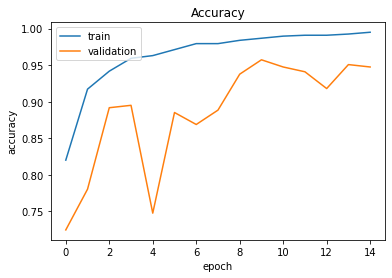

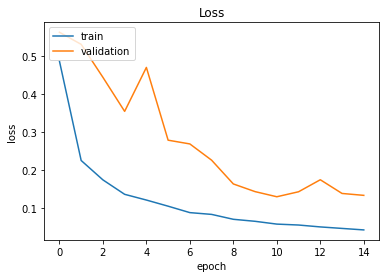

In [13]:
#plot accuracy and loss for training and validation vs. epochs
plt.title('Accuracy')
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [14]:
#evaluate the model on test set set
with tf.device('/gpu:0'):
    result = model.evaluate(test_img, test_labels)
    evalDict = dict(zip(model.metrics_names, result))
print(evalDict)

10/10 [==============================] - 0s 28ms/step - loss: 0.0916 - accuracy: 0.9639
{'loss': 0.09155283123254776, 'accuracy': 0.9639344215393066}


In [15]:
#print the performance report based on classified objects
ypred = model.predict(test_img, verbose = 1)
pred_labels = ((ypred > 0.50)*1)
perf_report = classification_report(pred_labels, test_labels)
print(perf_report)

10/10 [==============================] - 0s 28ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       155
           1       0.96      0.97      0.96       150

    accuracy                           0.96       305
   macro avg       0.96      0.96      0.96       305
weighted avg       0.96      0.96      0.96       305

